<a href="https://colab.research.google.com/github/xerifg/Myipynb/blob/main/GAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

导入所需的库

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

我们将使用一个单一的图像作为真实的图像，以更快的训练和得到结果，所以图像生成的生成器将类似于这个图像，你也可以使用一组图像的数据，这一切由你。

我们将使用PIL library将图像加载为PIL image，然后使用torchvision transforms调整大小并将图像转换为张量，然后创建大小为(1×100)的伪噪声来生成图像

torch.Size([3, 32, 32])


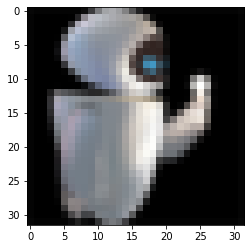

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()
])

flat_img = 3072  #32×32×3 --size of flattened image

img = Image.open('/content/drive/MyDrive/pictures/yiwa.jpeg')
real_img = transform(img)

torch.manual_seed(2)
fake_img = torch.rand(1, 100) # 返回0-1之间均匀分布的1*100大小的张量

plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))  # 正常(x,y,z)对应的是(0,1,2)
print(real_img.size())

创建一个判别器模型，它是一个全连接的神经网络，接收真实图像或伪图像，输出0或1

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    # nn.linear,用于设置网络中的全连接层
    # nn.Sequential,用于构造整个网络结构的容器
    self.linear = nn.Sequential(
        nn.Linear(flat_img, 10000),
        nn.ReLU(),
        nn.Linear(10000, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img = img.view(1, -1)  # 重置张量形状大小为1行，-1代表由计算机自行计算多少列
    out = self.linear(img)

    return out

创建一个生成器模型，它也是一个全连接的网络，接受随机噪声并输出一个与真实图像大小相同的图像张量。

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(100, 10000),
        nn.LeakyReLU(),
        nn.Linear(10000, 4000),
        nn.LeakyReLU(),
        nn.Linear(4000, flat_img)
    )

  def forward(self, latent_space):
    latent_space = latent_space.view(1, -1)
    out = self.linear(latent_space)

    return out

初始化模型，优化器和损失函数，然后将它们移动到所需的设备(cuda或cpu)。我们在判别器中使用二元交叉熵损失，并对生成器使用本文中讨论的损失函数log(1 - D(G(z))

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

discr = Discriminator().to(device)  # 初始化判别器模型
gen = Generator().to(device)  # 初始化生成器模型

opt_d = optim.SGD(discr.parameters(), lr=0.001, momentum=0.9)  # 优化器使用随机梯度下降
opt_g = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

criterion = nn.BCELoss()

现在我们对模型进行训练，整个GAN被训练500个大的epoch，判别器先训练4个epoch，然后生成器再训练3个epoch。

In [ ]:
epochs = 500
discr_e = 4 
gen_e = 3

#whole model training starts here
for epoch in tqdm(range(epochs), total=epochs):

  #discriminator training
  for k in range(discr_e):
    opt_d.zero_grad()  # 1.梯度清零，否则会在每次的循环中梯度发生累加
    # 根据pytorch中backward（）函数的计算，当网络参量进行反馈时，梯度是累积计算而不是被替换，
    #但在处理每一个batch时并不需要与其他batch的梯度混合起来累积计算，因此需要对每个batch调用一遍zero_grad（）将参数梯度置0.

    out_d1 = discr(real_img.to(device))  # 2.前向传播计算预测值
    #loss for real image
    loss_d1 = criterion(out_d1, torch.ones((1, 1)).to(device))  # 3.计算当前损失
    loss_d1.backward()  # 4.反向传播计算梯度

    out_d2 = gen(fake_img.to(device)).detach()  # detach():截断生成器的反响传播的梯度流,
    # 即后面的loss_d2.backward()计算梯度时只会影响判别器，不会影响生成器
    #loss for fake image
    loss_d2 = criterion(discr(out_d2.to(device)), torch.zeros((1, 1)).to(device))
    loss_d2.backward()

    opt_d.step() # 5.利用backward计算的梯度更新网络参数

  #generator training
  for i in range(gen_e):
    opt_g.zero_grad()  # 将模型的参数梯度初始化为0
    
    out_g = gen(fake_img.to(device))
    
    #Binary cross entropy loss
    #loss_g =  criterion(discr(out_g.to(device)), torch.ones(1, 1).to(device))

    #----Loss function in the GAN paper
    #[log(1 - D(G(z)))]
    loss_g = torch.log(1.0 - (discr(out_g.to(device)))) 
    loss_g.backward()

    opt_g.step()

  0%|          | 0/500 [00:00<?, ?it/s]

将生成的图像与真实图像进行比较。你可以调整学习率，动量，epochs以及生成器和判别器中的层以得到更好的结果。

tensor([[-0.4494,  0.3458, -0.1258,  ...,  0.1084, -0.2414,  0.1398]],
       grad_fn=<AddmmBackward>)


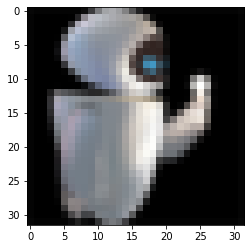

In [ ]:
out_g2 = gen(fake_img.to(device))  # 生成器根据随机数自主产生图片
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0))) 